<a href="https://colab.research.google.com/github/vijayshankarrealdeal/intro_to_pytorch-Gans/blob/main/SNGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [69]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [70]:
class Generator(nn.Module):
  def __init__(self, z_dim=10, im_chan=1, hidden_units=64):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
        self.make_gen_block(z_dim,hidden_units*4),
        self.make_gen_block(hidden_units*4,hidden_units*2,kernel_size = 4,stride = 1),
        self.make_gen_block(hidden_units*2,hidden_units),
        self.make_gen_block(hidden_units,im_chan,kernel_size = 4,final_layer = True)
    )

  def make_gen_block(self,input_units,output_units,kernel_size = 3,stride = 2,final_layer = False):
    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(input_units,output_units,kernel_size,stride),
          nn.BatchNorm2d(output_units),
          nn.ReLU(inplace = True)
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(input_units,output_units,kernel_size,stride),
          nn.Tanh()
      )
    
  def unsqueeze_noise(self,noise):
    return noise.view(len(noise),self.z_dim, 1, 1)
  
  def forward(self,noise):
    x = self.unsqueeze_noise(noise)
    return self.gen(x)

In [71]:
def get_noise(n_samples,z_dim,device = 'cpu'):
  return torch.randn(n_samples,z_dim,device = device)

In [72]:
class Discriminator(nn.Module):
  def __init__(self,im_cha = 1,hidden_units = 16):
    super(Discriminator,self).__init__()
    self.disc = nn.Sequential(
        self.make_disc_block(im_cha,hidden_units),
        self.make_disc_block(hidden_units,hidden_units*2),
        self.make_disc_block(hidden_units*2,1,final_layer = False)
    )
  
  def make_disc_block(self,input_units,output_units,kernel_size = 4, stride = 2,final_layer = False):
    if not final_layer:
      return nn.Sequential(
          nn.utils.spectral_norm(nn.Conv2d(input_units,output_units,kernel_size,stride)),
          nn.BatchNorm2d(output_units),
          nn.LeakyReLU(0.2,inplace = True)
      )
    else:
      return nn.Sequential(
          nn.utils.spectral_norm(nn.Conv2d(input_units,output_units,kernel_size,stride))
      )

  def forward(self,image):
    disc_pred = self.disc(image)
    return disc_pred.view(len(disc_pred),-1)


In [73]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128

lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(".", download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [74]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [75]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

Step 500: Generator loss: 0.6937020431756978, discriminator loss: 0.6959214667081839


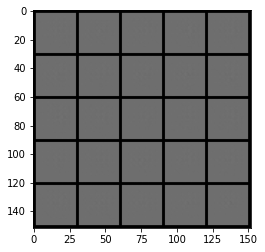

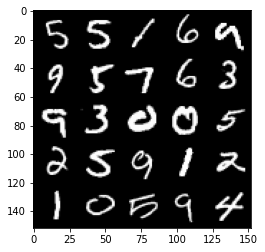

Step 1000: Generator loss: 0.6931436346769346, discriminator loss: 0.6931471803188349


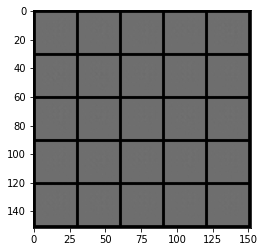

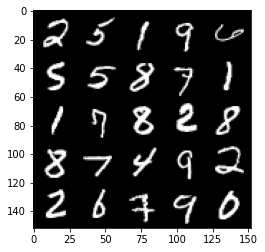

Step 1500: Generator loss: 0.693147182464603, discriminator loss: 0.693147182464603


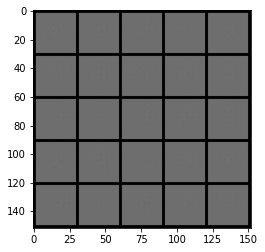

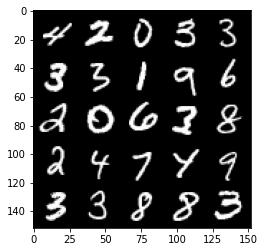

Step 2000: Generator loss: 0.693147182464603, discriminator loss: 0.6931471825838124


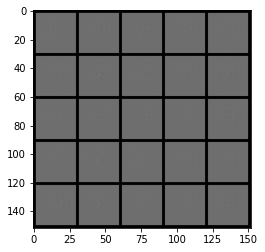

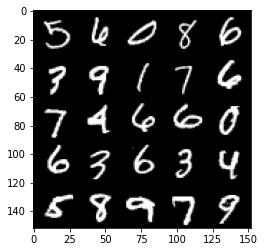

Step 2500: Generator loss: 0.693147182464603, discriminator loss: 0.6931471825838122


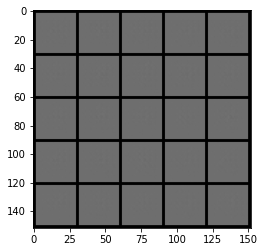

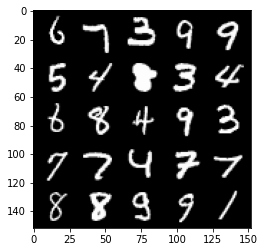

Step 3000: Generator loss: 0.693147182464603, discriminator loss: 0.6931471825838122


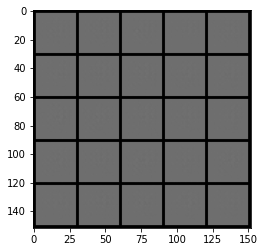

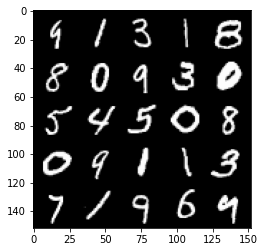

Step 3500: Generator loss: 0.693147182464603, discriminator loss: 0.6931471825838122


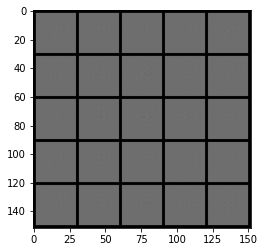

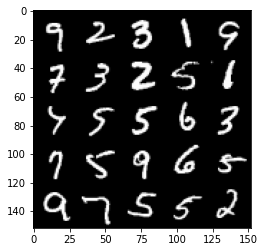

Step 4000: Generator loss: 0.693147182464603, discriminator loss: 0.6931471825838122


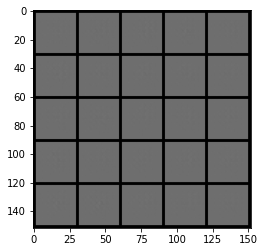

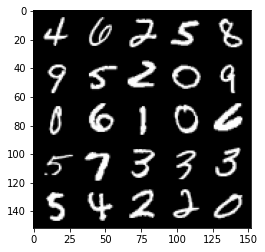

In [ ]:
for i in range(n_epochs):
  for real,_ in tqdm(dataloader):
    cur_batch_size = len(real)
    real = real.to(device)
    disc_opt.zero_grad()
    fake_noise = get_noise(cur_batch_size,z_dim,device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())

    disc_fake_loss = criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))

    disc_real_pred = disc(real)

    disc_real_loss = criterion(disc_real_pred,torch.ones_like(disc_real_pred))

    disc_loss = (disc_fake_loss + disc_real_loss)/2

    mean_discriminator_loss += disc_loss.item() / display_step

    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    gen_opt.zero_grad()
    fake_noise2 = get_noise(cur_batch_size, z_dim, device=device)
    fake_2 = gen(fake_noise2)
    disc_fake_pred  = disc(fake_2)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

    gen_loss.backward()
    gen_opt.step()

    mean_generator_loss += gen_loss.item() / display_step

    if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
    cur_step += 1




